In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

import math
from numba import jit
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
# plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

from scipy.stats import norm
from math import log, sqrt, pi, exp
from scipy import stats



In [2]:
def mcs_simulation(S0, r, b, T, sigma, paths, steps):
    """
    Monte Carlo Simulation, MCS
    S0:期初价格
    r:折现率
    b:持有成本，b=r就是标准的无股利，b=r-q就是有股利模型 ***
    T：到期期限
    sigma：波动率
    paths:路径数
    steps：模拟天数
    """
    dt = T / steps
    S_path = np.zeros((steps + 1, paths))
    Time_path = np.zeros((steps + 1, 1))
    S_path[0] = S0
    Time_path[0] = 0
    for step in range(1, steps + 1):
        rn = np.random.standard_normal(paths)
        S_path[step] = S_path[step - 1] * np.exp((b - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * rn)  # 几何布朗运动的解
        Time_path[step] = step * dt
    return S_path, Time_path



In [3]:
# bs model 
def bsprice(s0, k, T, r, sig):
    """
    bs定价
    Black-Scholes price for a European call option.
    :param s0: 
    :param k: 
    :param T: 
    :param r: 
    :param sig: 
    :return: 
    """
    d1 = (np.log(s0 / k) + (r + 0.5 * sig ** 2) * T) / (sig * np.sqrt(T))
    d2 = d1 - sig * np.sqrt(T)
    option_price = s0 * stats.norm.cdf(d1) - k * np.exp(-r * T) * stats.norm.cdf(d2)
    return option_price


def bsdelta(s0, k, T, r, sig):
    """
    Delta of a European call option.
    Delta 的金融意义
    对冲比率：
    Delta 是动态对冲中需持有的标的资产数量。
    例如，Delta = 0.6 ⇒ 对冲 1 份期权需 0.6 股标的。
    价格敏感性：
    若标的资产价格上涨 1 元，期权价格约上涨 Delta × 1 元。
    ​看涨 vs 看跌期权：
    看涨期权 Delta ∈ [0, 1]。
    看跌期权 Delta ∈ [-1, 0]（公式为 N(d1)−1）。
    :param s0: 
    :param k: 
    :param T: 
    :param r: 
    :param sig: 
    :return: 
    """
    d1 = (np.log(s0 / k) + (r + 0.5 * sig ** 2) * T) / (sig * np.sqrt(T))
    delta = stats.norm.cdf(d1)
    return delta



# Parameters


In [32]:
S = 1
T = 1
sigma = 0.13
r = 0.03
b = 0.03
Strike = 1
optionType = "C"
paths = 2
steps = 252

In [33]:
S_path, Time_path = mcs_simulation(S, r, b, T, sigma, paths, steps)

In [35]:
S_path.shape

(253, 2)

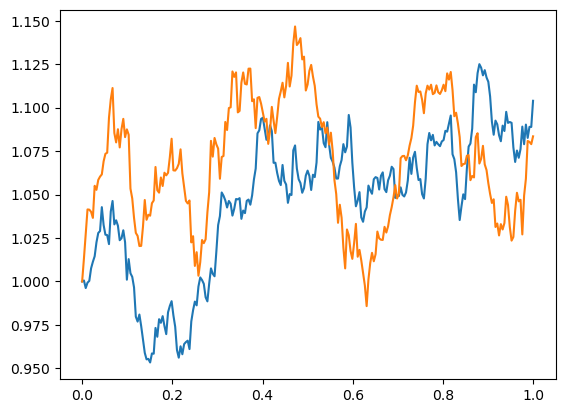

In [36]:

plt.plot(Time_path, S_path)

In [37]:
CallPrice = bsprice(S_path, Strike, T - Time_path, r, sigma)

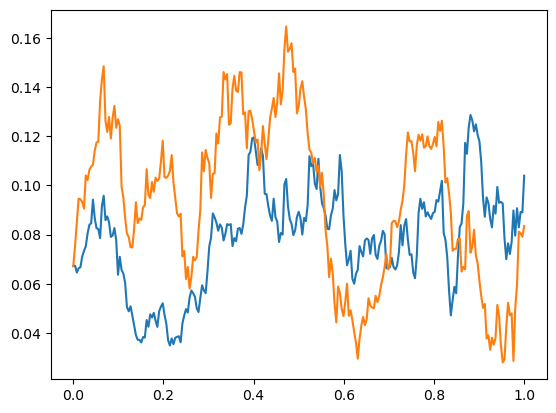

In [38]:
plt.plot(Time_path, CallPrice)

In [39]:
CallDelta = bsdelta(S_path, Strike, T - Time_path, r, sigma)

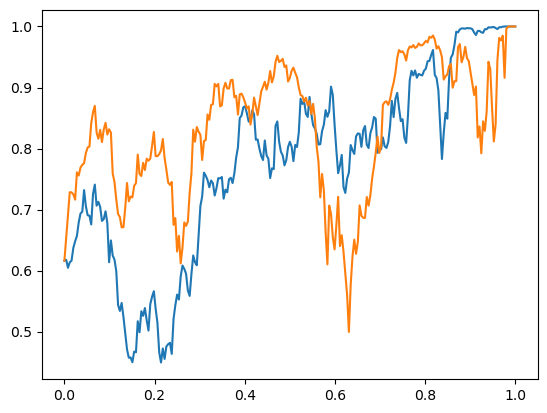

In [40]:
plt.plot(Time_path, CallDelta)


## Case 1: Assume that we would like to replicate these call options with delta hedging methods.

In [41]:
delta_rebalance_qty = pd.DataFrame(CallDelta).diff().values
delta_rebalance_qty[0, :] = 0.0
delta_rebalance_notional = delta_rebalance_qty * S_path

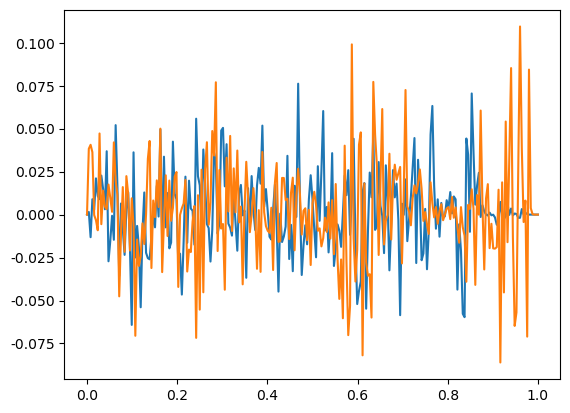

In [42]:
plt.plot(Time_path, delta_rebalance_notional)

In [43]:
dt = pd.DataFrame(Time_path).diff().values
dt[0, :] = 0.0

In [44]:
bank_account_balance = np.zeros((steps + 1, paths))

In [45]:
for i in range(1, len(bank_account_balance)):
    # print(i)
    bank_account_balance[i, :] = bank_account_balance[i - 1, :] * (np.exp(r * dt[i, :])) - delta_rebalance_notional[i,
                                                                                           :]


In [48]:
bank_account_balance

array([[ 0.00000000e+00,  0.00000000e+00],
       [-1.52918632e-03, -3.83102104e-02],
       [ 1.16087786e-02, -7.89383487e-02],
       [ 2.65401518e-03, -1.15253785e-01],
       [-1.70173551e-04, -1.14995284e-01],
       [-2.12564915e-02, -1.11749030e-01],
       [-3.20442178e-02, -1.02659451e-01],
       [-4.10310646e-02, -1.49879683e-01],
       [-6.37325463e-02, -1.44322270e-01],
       [-7.86277420e-02, -1.58258996e-01],
       [-8.17507571e-02, -1.62915841e-01],
       [-1.18630642e-01, -1.66080411e-01],
       [-9.14828181e-02, -1.83585084e-01],
       [-7.61731919e-02, -1.93421927e-01],
       [-7.54847118e-02, -1.95066694e-01],
       [-6.08334035e-02, -2.37123797e-01],
       [-1.12905650e-01, -2.56924018e-01],
       [-1.28834035e-01, -2.68511137e-01],
       [-9.32064475e-02, -2.20978669e-01],
       [-9.96716027e-02, -2.10046135e-01],
       [-9.10746268e-02, -2.26077939e-01],
       [-6.76488807e-02, -2.04451972e-01],
       [-7.07979155e-02, -2.26861648e-01],
       [-8.

In [46]:
total_value_portfolio = bank_account_balance + CallDelta * S_path

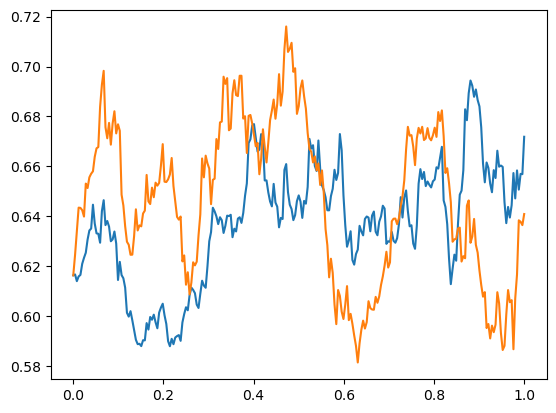

In [47]:
plt.plot(Time_path, total_value_portfolio)

## Case 2: Buy a call option, and then sell the Delta Stock for delta hedge

In [19]:
option_qty = 1
steps = 252
S_path, Time_path = mcs_simulation(S, r, b, T, sigma, paths, steps)


In [20]:

CallPrice = bsprice(S_path, Strike, T - Time_path, r, sigma * 0.5)
CallDelta = bsdelta(S_path, Strike, T - Time_path, r, sigma * 0.5)

In [21]:
dt = pd.DataFrame(Time_path).diff().values
dt[0, :] = 0.0

In [22]:


option_account_value = CallPrice * option_qty

In [23]:
underlying_hedge_account_value = option_qty * CallDelta * (-1) * S_path
underlying_hedge_account_qty = option_qty * CallDelta * (-1)

In [24]:
delta_rebalance_qty = pd.DataFrame(underlying_hedge_account_qty).diff().values
delta_rebalance_qty[0, :] = underlying_hedge_account_value[0, :]
delta_rebalance_notional = delta_rebalance_qty * S_path

In [25]:
bank_account_value = np.zeros((steps + 1, paths))
bank_account_value[0, :] = (-1) * (underlying_hedge_account_value[0, :] + option_account_value[0, :])

for i in range(1, len(bank_account_value)):
    bank_account_value[i, :] = bank_account_value[i - 1, :] * (np.exp(r * dt[i, :])) - delta_rebalance_notional[i, :]

In [26]:
total_value_portfolio = option_account_value + underlying_hedge_account_value + bank_account_value

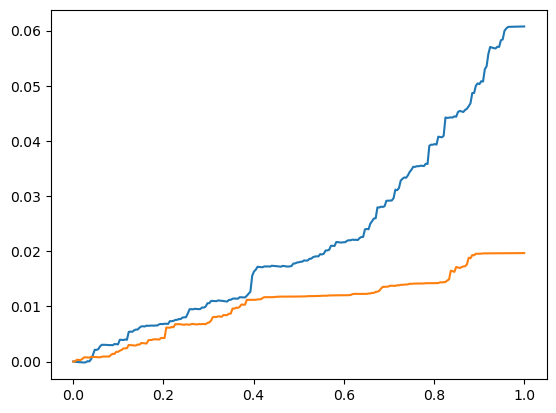

In [27]:
plt.plot(Time_path, total_value_portfolio)

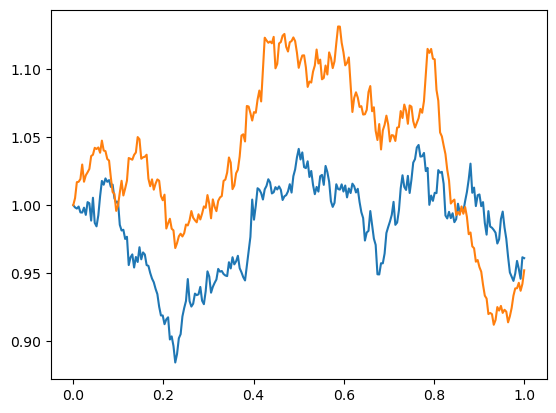

In [28]:

plt.plot(Time_path, S_path)

In [29]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from matplotlib import pyplot as plt
from math import log, sqrt, pi, exp
from scipy import stats



In [30]:
# bs model 
def bsprice(s0, k, T, r, sig):
    d1 = (np.log(s0 / k) + (r + 0.5 * sig ** 2) * T) / (sig * np.sqrt(T))
    d2 = d1 - sig * np.sqrt(T)
    option_price = s0 * stats.norm.cdf(d1) - k * np.exp(-r * T) * stats.norm.cdf(d2)
    return option_price


def bsdelta(s0, k, T, r, sig):
    d1 = (np.log(s0 / k) + (r + 0.5 * sig ** 2) * T) / (sig * np.sqrt(T))
    delta = stats.norm.cdf(d1)
    return delta



In [31]:
def stock_paths_daily(S0, mu, sigma, T, M, times):
    dt = float(T) / M  # time step, 1 day
    paths = np.zeros((M + 1, times), np.float64)
    paths[0] = S0
    for t in range(1, M + 1):
        rand = np.random.standard_normal(times)
        paths[t] = paths[t - 1] * np.exp((mu - 0.5 * sigma ** 2) * dt +
                                         sigma * np.sqrt(dt) * rand)
    return paths
